In [1]:
%load_ext autoreload
%autoreload 2

import os 
from os.path import join 
from glob import glob 
from tqdm.auto import tqdm
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
from hshadow_render import hshadow_render
from hshadow_render import style_hardshadow as softshadow_render

import sys
import inspect

from camera import axis_camera
from reflect_render import *
from xyh_proj import xyz2xyh, xyh2xyz, compute_normal, get_ray_mat, normalize_vec3

def show(img, title=''):
    print(img.shape, img.min(), img.max())
    plt.figure(figsize=(15,10))
    plt.imshow(img)
    plt.title(title)
    plt.show()

def show_tensor(tensor,title=''):
    img = utils.make_grid(tensor).detach().cpu().numpy().transpose(1,2,0)
    show(img, title=title)

def parse_configs(config):
    with open(config, 'r') as stream:
        try:
            configs=yaml.safe_load(stream)
            return configs
        except yaml.YAMLError as exc:
            logging.error(exc)
            return {}

        

In [2]:
# shadow related functions 
def proj_horizon_plane(p):
    pp = p.copy()
    pp[1] = pp[1] + pp[2] 
    pp[2] = pp[2] * 0.0
    return pp

def compute_light_pos(p0, p1, light_horizon):
    """ Given a pair of xyh and light h, compute the light height
    """ 
    if len(p0) != 3 or len(p1) !=3:
        raise ValueError('Input size {},{} is wrong(should be 3).'.format(p0.shape, p1.shape))

    x0, y0, h0, x1, y1, h1 = p0[0], p0[1], p0[2], p1[0], p1[1], p1[2]
    light_sign = ((y1+h1)-(y0+h0))/np.abs((y1+h1)-(y0+h0))
    print('light sign: ', light_sign)

    # import pdb; pdb.set_trace()
    pp0, pp1 = proj_horizon_plane(p0), proj_horizon_plane(p1) 
    t = (light_horizon - pp0[1])/(pp1[1]-pp0[1])
    lightx, lighty, lighth = (1.0-t)*x0 + t*x1, (1.0-t)*y0+t*y1, (1.0-t)*h0 + t * h1
    return np.array([lightx, lighty, lighth])


from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def composite(rgb, mask, shadow):
    return rgb * mask + (1.0-mask) * shadow

In [3]:
def composite_reflection(rgb, mask, fg_pixht, bg_rgba, bg_pixht, rechmap, horizon, sample=10, glossness=0.05):
    params = {
        'sample_n': sample,
        'horizon': horizon,
        'ref_idx': 0.3,
        'glossness': glossness,
        'dh': 1.0,
        'batch_size': 1,
        'reflect_alpha': 1.0,
        'camera_h': 10
    }
    
    fg_rgba = np.concatenate([rgb, mask], axis=2)
    fg_height = fg_pixht
    bg_height = rechmap
    bg_reflection_layer = bg_rgba[..., -1:]

    reflection_rgb = reflection_layer(fg_rgba, fg_height, bg_rgba, bg_height, bg_reflection_layer, params)
    
    comp = rgb * mask + (1.0-mask) * reflection_rgb
    return comp



In [4]:
def render_shadow(rgb, mask, fg_pixht, bg_pixht, rechmap, x, y, horizon, softness=0.9):
    tmphmap = mask * fg_pixht
    mask_top_pos = list(np.unravel_index(np.argmax(tmphmap), tmphmap.shape))
    mask_top_pos = [mask_top_pos[1], mask_top_pos[0], tmphmap.max()]
    
    mouse_p = np.array([x, y, rechmap[y, x, 0]])
    light_xyh = compute_light_pos(mouse_p, mask_top_pos, horizon)
    
    tmp_mask = mask.copy()
    tmp_mask[tmp_mask>0.0] = 1.0
    
    fg_pixht = fg_pixht * mask
    bg_pixht = bg_pixht * mask
    
    fg_min = fg_pixht[tmp_mask != 0].min()
    fg_pixht -= fg_min
    bg_pixht -= fg_min
    
    last_pos = [0, 0]
    fg_shadow = hshadow_render(rgb, mask, fg_pixht, rechmap, light_xyh, last_pos)
    bg_shadow = hshadow_render(rgb, mask, bg_pixht, rechmap, light_xyh, last_pos)
    
    return fg_shadow, bg_shadow


In [5]:
root = 'Examples'
fg_rgba1 = plt.imread(join(root, '009_rgb.png'))
fg_rgba2 = plt.imread(join(root, '010_rgb.png'))
fg_rgba3 = plt.imread(join(root, '011_rgb.png'))

fg_pixht1 = np.load(join(root, '009_pixht_new.npy'))
fg_pixht2 = np.load(join(root, '010_pixht_new.npy'))
fg_pixht3 = np.load(join(root, '011_pixht_new.npy'))

mask1 = np.load(join(root, '009_depth_valid_mask.npy'))
mask2 = np.load(join(root, '010_depth_valid_mask.npy'))
mask3 = np.load(join(root, '011_depth_valid_mask.npy'))

bg = plt.imread(join(root, 'c82c09fc01e84282bc8870c263dcf81b_bg.jpg')) / 255.0

cur_rgb = fg_rgba1.copy()
cur_mask = mask1.copy()[..., None]
cur_fg_pixht = fg_pixht1.copy()[..., None]
cur_bg_pixht = fg_pixht1.copy()[..., None]

h, w = bg.shape[:2]

bg = cv2.resize(bg, (w//4, h//4))

In [6]:
def composite(rgb1, rgb2, mask1):
    return rgb1 * mask1 + rgb2 * (1.0-mask1)


def safe_comp(rgb1, rgb2, mask1, topleft):
    h1, w1 = rgb1.shape[:2]
    h2, w2 = rgb2.shape[:2]
    
    h_ = topleft[0]
    w_ = topleft[1]
    
    h__ = h_ + h1
    w__ = w_ + w1
    
    h_1 = np.clip(h_, 0, h2)
    w_1 = np.clip(w_, 0, w2)
    
    h__1 = np.clip(h__, 0, h2)
    w__1 = np.clip(w__, 0, w2)
    
    delta_h = h__ -  h__1
    delta_w = w__ - w__1
    
    cur_rgb1 = rgb1[:h1-delta_h, :w1 - delta_w]
    cur_mask1 = mask1[:h1-delta_h, :w1 - delta_w]
    
    rgb2[h_:h__1, w_:w__1] = composite(cur_rgb1, rgb2[h_:h__1, w_:w__1], cur_mask1)
    return rgb2


top_left1 = [500, 360]
size1 = [512, 512]

cur_slice_h = slice(top_left1[0], top_left1[0] + size1[0])
cur_slice_w = slice(top_left1[1], top_left1[1] + size1[1])

cur_bg = bg.copy()
new_fg_rgb = np.zeros_like(cur_bg)
new_fg_mask = np.zeros_like(cur_bg)
new_fg_pixht = np.zeros_like(cur_bg)

cur_bg = safe_comp(cur_rgb, cur_bg, cur_mask, top_left1)
new_fg_rgb = safe_comp(cur_rgb, new_fg_rgb, cur_mask, top_left1)
new_fg_mask = safe_comp(cur_mask, new_fg_mask, cur_mask, top_left1)

new_fg_pixht = safe_comp(cur_fg_pixht, new_fg_pixht, cur_mask, top_left1)
new_bg_pixht = new_fg_pixht.copy() 

# show(new_fg_pixht)
# show(cur_bg)
# show(new_fg_rgb)
# show(new_fg_mask)

h, w = cur_bg.shape[:2]
cur_bg_rgba = np.ones((h, w, 4))
cur_bg_rgba[..., :3] = cur_bg

(893, 1300, 3)
(893, 1300, 1)
(893, 1300, 1)
(893, 1300, 1)
(893, 1300, 1)
light sign:  -1.0
light sign:  -1.0


/home/ysheng/Documents/Research/EXP/PixHtLab-Src/Demo/PixhtLab/reflect_render.py:157: RuntimeWarning: invalid value encountered in divide
  return vec3/np.linalg.norm(vec3, axis=-1, keepdims=True)
Render: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


(893, 1300, 3) 0.0 1.0


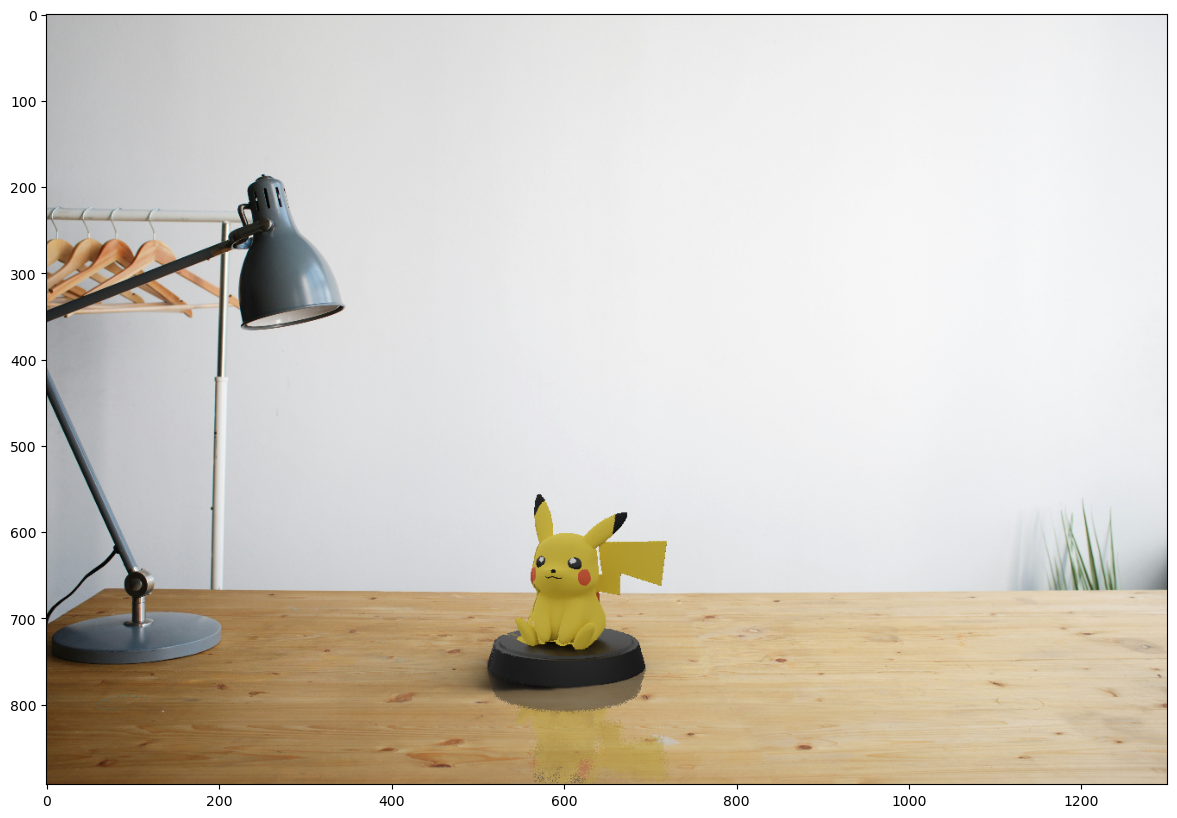

In [7]:
rechmap = np.zeros_like(new_fg_rgb)[..., 0:1]

new_fg_mask = new_fg_mask[..., 0:1]
new_fg_pixht = new_fg_pixht[..., 0:1]
new_bg_pixht = new_bg_pixht[..., 0:1]

x = 455
y = 776
horizon = 600
softness = 0.1

print(new_fg_rgb.shape)
print(new_fg_mask.shape)
print(new_fg_pixht.shape)
print(new_bg_pixht.shape)
print(rechmap.shape)

ao_shadow, bg_shadow = render_shadow(new_fg_rgb, new_fg_mask, new_fg_pixht, new_bg_pixht, rechmap, x, y, horizon)
fg_shadow, bg_shadow = render_shadow(new_fg_rgb, new_fg_mask, new_fg_pixht, new_bg_pixht, rechmap, 455, 776, horizon)

ao_weight = 0.5
ao_softness = 0.2
glossness = 0.01
sample = 1

ao_ss = softshadow_render(new_fg_mask[..., :1], ao_shadow[..., :1], ao_softness)[0]
dir_ss = softshadow_render(new_fg_mask[..., :1], fg_shadow[..., :1], softness)[0]
final_ss = 1.0 - ((1.0 - ao_ss) * ao_weight  + (1.0 - dir_ss) * (1.0-ao_weight) )
shadow_bg = composite(new_fg_rgb, final_ss * cur_bg_rgba[..., :3], new_fg_mask)
cur_bg_rgba[..., :3] = shadow_bg
final = composite_reflection(new_fg_rgb, new_fg_mask, new_fg_pixht, cur_bg_rgba, new_bg_pixht, rechmap, horizon=horizon, glossness=glossness, sample=sample) 

show(final)